In [1]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
class LandmarksCSV(Dataset):
    """
    PyTorch Dataset that:
      - Reads a CSV file with columns: 
          class_label, x1…x68, y1…y68
      - Optionally uses only the first n_rows rows.
      - For each row, extracts two float vectors of length 68 (x’s and y’s),
        stacks them into a tensor of shape (2, 68), and returns (coords, label_idx).
    """
    def __init__(self, csv_path: str, n_rows: int = None):
        """
        Args:
            csv_path (str): Path to the CSV file.
            n_rows (int, optional): If not None, only read the first n_rows of the CSV.
        """
        # 1. Load the CSV into a pandas DataFrame
        self.df = pd.read_csv(csv_path)
        if n_rows is not None:
            # Keep only the first n_rows
            self.df = self.df.iloc[:n_rows].reset_index(drop=True)
        
        # 2. Build a mapping from class_label (string) → integer index
        #    (sorted to ensure reproducibility)
        classes = sorted(self.df["class_label"].unique().tolist())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        # 3. Precompute the column names for x’s and y’s
        self.x_cols = [f"x{i}" for i in range(1, 69)]  # ["x1", "x2", …, "x68"]
        self.y_cols = [f"y{i}" for i in range(1, 69)]  # ["y1", "y2", …, "y68"]
        
        # 4. (Optional) sanity check: ensure all those columns exist
        missing = set(self.x_cols + self.y_cols) - set(self.df.columns)
        if missing:
            raise ValueError(f"Missing columns in CSV: {missing}")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        """
        Returns:
            coords (torch.FloatTensor): shape (2, 68), where
                coords[0, :] = [x1, x2, …, x68]
                coords[1, :] = [y1, y2, …, y68]
            label_idx (int): integer label for this row’s class_label
        """
        row = self.df.iloc[idx]
        
        # 1. Get the class label and convert to integer index
        cls_str = row["class_label"]
        label_idx = self.class_to_idx[cls_str]
        
        # 2. Extract x-values (as a numpy array of shape (68,))
        x_vals = row[self.x_cols].to_numpy(dtype=np.float32)
        # 3. Extract y-values (as a numpy array of shape (68,))
        y_vals = row[self.y_cols].to_numpy(dtype=np.float32)
        
        # 4. Convert to torch.Tensor
        x_tensor = torch.from_numpy(x_vals/320)  # shape: (68,)
        y_tensor = torch.from_numpy(y_vals/320)  # shape: (68,)

        
        # 5. Stack into shape (2, 68) so conv1d can treat these as 2 channels
        coords = torch.stack([x_tensor, y_tensor], dim=0)
        #    → coords.shape == (2, 68)
        
        return coords, label_idx


In [ ]:
class Conv1DBinaryClassifier(nn.Module):
    def __init__(self, dropout_p: float = 0.3):
        super().__init__()

        # Conv block 1: 2 → 16
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=1)
        self.bn1   = nn.BatchNorm1d(16)

        flattened_size = 68

        # Dense head: 68 → 128 → 64 → 1
        self.fc1    = nn.Linear(flattened_size, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)

        self.fc2    = nn.Linear(128, 32)
        self.bn_fc2 = nn.BatchNorm1d(32)

        self.drop   = nn.Dropout(p=dropout_p)
        self.fc3    = nn.Linear(32, 1)

        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        # x: (batch, 2, 68)
        x = self.conv1(x)     # → (batch, 16, 68)
        x = self.bn1(x)
        x = F.relu(x)

        # Step 1: Permute to make channels to the last dimension
        x = x.permute(0, 2, 1)   # [128, 68, 16]
        x = self.pool(x)     # → (batch, 68)

        x = x.view(x.size(0), -1)  # → (batch, 68)

        x = self.fc1(x)       # → (batch, 128)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.drop(x)      # → (batch, 128)

        x = self.fc2(x)       # → (batch, 32)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.drop(x)      # → (batch, 32)

        logit = self.fc3(x)   # → (batch, 1)
        return logit


In [11]:
csv_path = "updated_csv.csv"
n_rows   = None         # or e.g. 5000 to use only first 5000 rows

batch_size = 256
num_epochs = 15
learning_rate = 5e-4
print_every   = 50     # how often to update tqdm postfix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# 2.1) Create the full dataset
full_dataset = LandmarksCSV(csv_path, n_rows=n_rows)
total_samples = len(full_dataset)

# 2.2) Compute sizes
val_size   = int(0.10 * total_samples)
train_size = total_samples - val_size

# 2.3) Random split (use a fixed seed for reproducibility)
torch.manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Total samples: {total_samples}")
print(f" → Train:      {len(train_dataset)}")
print(f" → Validation: {len(val_dataset)}")

# 2.4) Check class balance roughly (optional)
#    If you want to see how many of each class are in train vs val, you can do:
from collections import Counter
train_labels = [full_dataset.df.iloc[i]["class_label"] for i in train_dataset.indices]
val_labels   = [full_dataset.df.iloc[i]["class_label"] for i in val_dataset.indices]
print("Train class counts:", Counter(train_labels))
print("Val   class counts:", Counter(val_labels))


Total samples: 107042
 → Train:      96338
 → Validation: 10704
Train class counts: Counter({'distracted': 48172, 'drowsy': 48166})
Val   class counts: Counter({'drowsy': 5355, 'distracted': 5349})


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,    # set >0 only if you wrap scripts under `if __name__=="__main__"`
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,    # no need to shuffle validation
    num_workers=0,
    pin_memory=False
)

print(f"Train loader: {len(train_loader)} batches per epoch")
print(f"Val   loader: {len(val_loader)} batches per epoch")


Train loader: 377 batches per epoch
Val   loader: 42 batches per epoch


In [7]:
model = Conv1DBinaryClassifier(dropout_p=0.5).to(device)
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Build idx_to_class for possible accuracy calculation
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
print("Class → index mapping:", full_dataset.class_to_idx)


Class → index mapping: {'distracted': 0, 'drowsy': 1}


In [14]:
train_losses_per_epoch = []
val_losses_per_epoch   = []
train_accs_per_epoch   = []
val_accs_per_epoch     = []

sigmoid = torch.nn.Sigmoid()

for epoch in range(num_epochs):
    # -------------------------
    # 5.1) Training Phase
    # -------------------------
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    num_train_batches = len(train_loader)
    loop = tqdm(enumerate(train_loader, start=1),
                total=num_train_batches,
                desc=f"Epoch {epoch+1}/{num_epochs} (train)",
                ncols=80,
                leave=False)

    for batch_idx, (coords, label_idxs) in loop:
        coords = coords.to(device, dtype=torch.float32)              # (B,2,68)
        labels = label_idxs.to(device, dtype=torch.float32).unsqueeze(1)  # (B,1)

        optimizer.zero_grad()
        logits = model(coords)                     # (B,1)
        loss   = criterion(logits, labels)         # scalar

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * coords.size(0)

        # Compute training accuracy on this batch:
        with torch.no_grad():
            probs = sigmoid(logits)                # (B,1)
            preds = (probs >= 0.5).long()          # (B,1)
            correct_train += (preds.view(-1) == label_idxs.to(device)).sum().item()
            total_train   += coords.size(0)

        # Update tqdm postfix every print_every
        if batch_idx % print_every == 0 or batch_idx == num_train_batches:
            avg_loss_so_far = running_train_loss / (batch_idx * batch_size)
            loop.set_postfix_str(f"Batch {batch_idx}/{num_train_batches}  AvgLoss: {avg_loss_so_far:.4f}")

    loop.close()

    epoch_train_loss = running_train_loss / train_size
    epoch_train_acc  = correct_train / total_train
    train_losses_per_epoch.append(epoch_train_loss)
    train_accs_per_epoch.append(epoch_train_acc)

    # -------------------------
    # 5.2) Validation Phase
    # -------------------------
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val   = 0

    num_val_batches = len(val_loader)
    loop_v = tqdm(enumerate(val_loader, start=1),
                  total=num_val_batches,
                  desc=f"Epoch {epoch+1}/{num_epochs} (val)",
                  ncols=80,
                  leave=False)

    with torch.no_grad():
        for batch_idx, (coords, label_idxs) in loop_v:
            coords = coords.to(device, dtype=torch.float32)
            labels = label_idxs.to(device, dtype=torch.float32).unsqueeze(1)

            logits = model(coords)                # (B,1)
            loss   = criterion(logits, labels)    # scalar
            running_val_loss += loss.item() * coords.size(0)

            # Compute validation accuracy
            probs = sigmoid(logits)
            preds = (probs >= 0.5).long()         # (B,1)
            correct_val += (preds.view(-1) == label_idxs.to(device)).sum().item()
            total_val   += coords.size(0)

    loop_v.close()

    epoch_val_loss = running_val_loss / val_size
    epoch_val_acc  = correct_val / total_val
    val_losses_per_epoch.append(epoch_val_loss)
    val_accs_per_epoch.append(epoch_val_acc)

    # -------------------------
    # 5.3) Print Epoch Summary
    # -------------------------
    print(
        f"Epoch {epoch+1}/{num_epochs}  "
        f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}  ||  "
        f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}"
    )


Epoch 1/15  Train Loss: 0.1701, Train Acc: 0.9398  ||  Val Loss: 0.1444, Val Acc: 0.9531


Epoch 2/15  Train Loss: 0.1532, Train Acc: 0.9478  ||  Val Loss: 0.2106, Val Acc: 0.9096


Epoch 3/15  Train Loss: 0.1428, Train Acc: 0.9513  ||  Val Loss: 0.1813, Val Acc: 0.9304


Epoch 4/15  Train Loss: 0.1321, Train Acc: 0.9548  ||  Val Loss: 0.2939, Val Acc: 0.8691


Epoch 5/15  Train Loss: 0.1225, Train Acc: 0.9584  ||  Val Loss: 0.1211, Val Acc: 0.9502


Epoch 6/15  Train Loss: 0.1164, Train Acc: 0.9612  ||  Val Loss: 0.1073, Val Acc: 0.9629


Epoch 7/15  Train Loss: 0.1095, Train Acc: 0.9635  ||  Val Loss: 0.1280, Val Acc: 0.9455


Epoch 8/15  Train Loss: 0.1058, Train Acc: 0.9640  ||  Val Loss: 0.1278, Val Acc: 0.9528


Epoch 9/15  Train Loss: 0.1028, Train Acc: 0.9658  ||  Val Loss: 0.2144, Val Acc: 0.9167


Epoch 10/15  Train Loss: 0.0971, Train Acc: 0.9674  ||  Val Loss: 0.0696, Val Acc: 0.9777


Epoch 11/15  Train Loss: 0.0956, Train Acc: 0.9676  ||  Val Loss: 0.1275, Val Acc: 0.9541


Epoch 12/15  Train Loss: 0.0912, Train Acc: 0.9696  ||  Val Loss: 0.1929, Val Acc: 0.9224


Epoch 13/15  Train Loss: 0.0875, Train Acc: 0.9698  ||  Val Loss: 0.1825, Val Acc: 0.9339


Epoch 14/15  Train Loss: 0.0851, Train Acc: 0.9708  ||  Val Loss: 0.2049, Val Acc: 0.9199


Epoch 15/15  Train Loss: 0.0858, Train Acc: 0.9706  ||  Val Loss: 0.0618, Val Acc: 0.9780


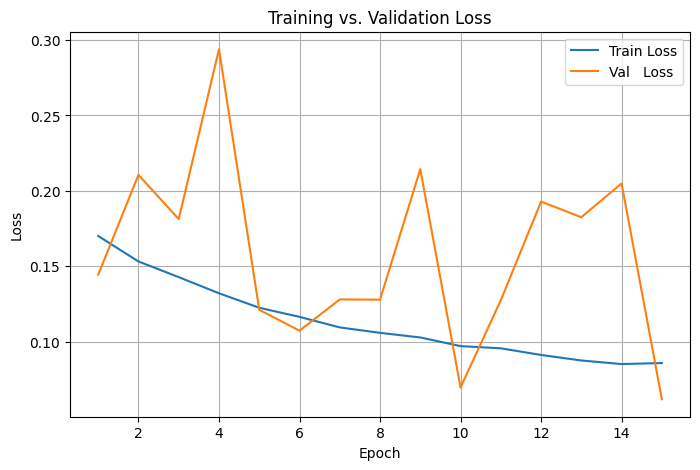

In [15]:
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_per_epoch, label="Train Loss")
plt.plot(epochs, val_losses_per_epoch,   label="Val   Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
checkpoint = {
    "model_state_dict": model.state_dict(),
    "class_to_idx": full_dataset.class_to_idx
}

save_path = "saved_landmark_model.pth"
torch.save(checkpoint, save_path)
print(f"[+] Model checkpoint saved to: {save_path}")


[+] Model checkpoint saved to: saved_landmark_model.pth
